In [10]:
from util import *
from eval import *
from data import FacesDataset, data_transform
import time
# from ..utils.data import FacesDataset, data_transform
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import matplotlib.pyplot as plt
from demo import RequestDetails

In [5]:
def process_request(request_details):
	model_to_use = None
	# print(three_task_table)
	task_count = len(request_details.tasks)
	if(task_count > 1):
		for latency in three_task_table["age"]:
			if(latency <= request_details.latency):
				if(model_to_use == None):
					model_to_use = three_task_table["age"][latency]
				else:	
					mean_acc = (float(three_task_table["age"][latency].accuracy[0]) + float(three_task_table["gender"][latency].accuracy[1]) + float(three_task_table["ethnicity"][latency].accuracy[2])) / 3.0
					mean_acc_existing = (float(model_to_use.accuracy[0]) + float(model_to_use.accuracy[1]) + float(model_to_use.accuracy[2]))/3.0 
					if(mean_acc_existing < mean_acc): model_to_use = three_task_table["age"][latency] 
	else:
		if(request_details.tasks[0] == "age"):
			for latency in age_task_table["age"]:
				if(latency <= request_details.latency):
					if(model_to_use == None):
						model_to_use = age_task_table["age"][latency]
					else:
						if(model_to_use.accuracy[0] < float(age_task_table["age"][latency].accuracy[0])):
							model_to_use = age_task_table["age"][latency]
		elif(request_details.tasks[0] == "gender"):
			for latency in gender_task_table["gender"]:
				if(latency <= request_details.latency):
					if(model_to_use == None):
						model_to_use = gender_task_table["gender"][latency]	
					else:
						if(model_to_use.accuracy[0] < float(gender_task_table["gender"][latency].accuracy[0])):
							model_to_use = gender_task_table["gender"][latency]
		elif(request_details.tasks[0] == "ethnicity"):	
			for latency in ethnicity_task_table["ethnicity"]:
				if(latency <= request_details.latency):
					if(model_to_use == None):
						model_to_use = ethnicity_task_table["ethnicity"][latency]	
					else:
						if(model_to_use.accuracy[0] < float(ethnicity_task_table["ethnicity"][latency].accuracy[0])):
							model_to_use = ethnicity_task_table["ethnicity"][latency]

	if(model_to_use == None):
		## Cannot meet latency requirement with any model
		return None, None
	else:
		model = torch.load(model_to_use.file_path, map_location=torch.device('cpu'))
		# model = torch.load(model_to_use.file_path)
		# model.cuda()
		model.cpu()
		# output = model(request_details.input_image.cuda())
		return output, model_to_use.latency
		if(task_count > 1):
			return output, (float(model_to_use.accuracy[0]) + float(model_to_use.accuracy[1]) + float(model_to_use.accuracy[2]))/3.0
		else:
			return output, model_to_use.accuracy[0]

def process_request_with_accuracy(request_details):
	model_to_use = None
	task_count = len(request_details.tasks)
	if(task_count > 1):
		for latency in three_task_table["age"]:
			# print(float(three_task_table["gender"][latency].accuracy[1]), request_details.accuracy[1])
			mean_acc = float(three_task_table["age"][latency].accuracy[0]) >= request_details.accuracy[0] and\
				float(three_task_table["gender"][latency].accuracy[1]) >= request_details.accuracy[1] and\
				float(three_task_table["ethnicity"][latency].accuracy[2]) >= request_details.accuracy[2]
			if(latency <= request_details.latency-10 and mean_acc == True):
					model_to_use = three_task_table["age"][latency]
	else:
		if(request_details.tasks[0] == "age"):
			for latency in age_task_table["age"]:
				if(latency <= request_details.latency-10 and float(age_task_table["age"][latency].accuracy[0]) >= request_details.accuracy):
					if(model_to_use == None):
						model_to_use = age_task_table["age"][latency]	
					else:
						if(float(model_to_use.accuracy[0]) < float(age_task_table["age"][latency].accuracy[0])):
							model_to_use = age_task_table["age"][latency]
		elif(request_details.tasks[0] == "gender"):
			for latency in gender_task_table["gender"]:
				if(latency <= request_details.latency-10and float(gender_task_table["gender"][latency].accuracy[0]) >= request_details.accuracy):
					if(model_to_use == None):
						model_to_use = gender_task_table["gender"][latency]	
					else:
						if(float(model_to_use.accuracy[0]) < float(gender_task_table["gender"][latency].accuracy[0])):
							model_to_use = gender_task_table["gender"][latency]
		elif(request_details.tasks[0] == "ethnicity"):	
			for latency in ethnicity_task_table["ethnicity"]:
				if(latency <= request_details.latency-10 and float(ethnicity_task_table["ethnicity"][latency].accuracy[0]) >= request_details.accuracy):
					if(model_to_use == None):
						model_to_use = ethnicity_task_table["ethnicity"][latency]	
					else:
						if(float(model_to_use.accuracy[0]) < float(ethnicity_task_table["ethnicity"][latency].accuracy[0])):
							model_to_use = ethnicity_task_table["ethnicity"][latency]

	if(model_to_use == None):
		## Cannot meet latency/accuracy requirement with any model
		return None, None
	else:
		# print("asd", request_details.tasks)
		# print(model_to_use.latency, end=" ")
		model = torch.load(model_to_use.file_path, map_location=torch.device('cpu'))
		# model = torch.load(model_to_use.file_path)
		# model.cuda()
		model.cpu()
		# output = model(request_details.input_image.cuda())
		output = model(request_details.input_image)
		return output, model_to_use.accuracy[0]
		# return output, model_to_use.latency

def process_batch_requests(requests, min_accuracy=False, mtl_model=True, only_mtl=False):
	use_gpu = False
	## Can write some queing stuff
	## iterate on the requests and call process_request
	latency_hit = []
	accuracy_hit = []
	lat_acc_pair = []
	outputs, latencies = [], []
	for request in requests:
		if(min_accuracy):
			if use_gpu: # skip first sample (to avoid slow GPU processing on first sample)
				if(only_mtl):
					output, accuracy = process_request_only_mtl(request, with_accuracy=True)
				elif(mtl_model):
					output, accuracy = process_request_with_accuracy(request)
				else:                
					output, accuracy = process_request_single_model_system(request, with_accuracy=True)
                    
			start_time = time.time()
			if(only_mtl):
				output, accuracy = process_request_only_mtl(request, with_accuracy=True)
			elif(mtl_model):
				output, accuracy = process_request_with_accuracy(request)
			else:                
				output, accuracy = process_request_single_model_system(request, with_accuracy=True)
			end_time = time.time()
			inf_time = (end_time-start_time)*1000
			# print(inf_time, request.latency, accuracy)
			# print(inf_time, start_time, end_time)
			# print(inf_time)
			outputs.append(output)
			latencies.append(inf_time)
			if(inf_time <= request.latency + 5 and output!=None):
				latency_hit.append(1)
			else:
				latency_hit.append(0)

			if(accuracy!=None ):
				accuracy_hit.append(1)
			else:
				accuracy_hit.append(0)
			
		else:
			if use_gpu: # skip first sample (to avoid slow GPU processing on first sample)
				if(only_mtl):
					output, accuracy = process_request_only_mtl(request)
				elif(mtl_model):
					output, accuracy = process_request(request)
				else:
					output, accuracy = process_request_single_model_system(request)                
			start_time = time.time()
			if(only_mtl):
				output, accuracy = process_request_only_mtl(request)
			elif(mtl_model):
				output, accuracy = process_request(request)
			else:
				output, accuracy = process_request_single_model_system(request)
			end_time = time.time()
			inf_time = (end_time-start_time)*1000
			# print(inf_time, request.latency, accuracy)
			# print(inf_time, end_time, output)
			if(inf_time <= request.latency and output!=None):
				latency_hit.append(1)
			else:
				latency_hit.append(0)
			if (accuracy != None):
				lat_acc_pair.append([request.latency, accuracy])
	return outputs, latencies
	# return latency_hit, accuracy_hit, lat_acc_pair

In [ ]:
### Load in the data
folder = '../UTKFace'
transform = data_transform()
dataset = FacesDataset(folder=folder, transform=transform)

train_len = int(len(dataset)*0.8)
val_len = len(dataset) - train_len

train_dataset, val_dataset = random_split(dataset, [train_len, val_len], torch.Generator().manual_seed(8))


dataloader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)

In [ ]:
print("Loading all task models..")
### All three tasks
three_task_models = load_all_task_models_info(dataloader, "model_score_lookup_multitask.tsv", "../models/model_variants")
three_task_table = get_models_table(three_task_models)

print("Loading age models..")
### Age
age_task_models = load_one_task_models_info(dataloader, "model_score_lookup_multitask.tsv", "../models/model_variants", "age", True)
age_task_table = get_models_table(age_task_models)
print("Loading gender models..")
### Gender
gender_task_models = load_one_task_models_info(dataloader, "model_score_lookup_multitask.tsv", "../models/model_variants", "gender", True)
gender_task_table = get_models_table(gender_task_models)

print("Loading ethnicity models..")
### Ethnicity
ethnicity_task_models = load_one_task_models_info(dataloader, "model_score_lookup_multitask.tsv", "../models/model_variants/", "ethnicity", True)
ethnicity_task_table = get_models_table(ethnicity_task_models)




In [ ]:
latency = int(max(three_task_table["age"]))+10

data = next(iter(dataloader))
input_image = data[0][0]
age = data[1][0]
gender = data[2][0]
ethnicity = data[3][0]

In [11]:
requests = []
accuracy = [0.83, 0.92, 0.72] 
accuracy1 = [0.75, 0.90, 0.70]
requests.append(RequestDetails(accuracy, latency, ["age", "gender", "ethnicity"], input_image.unsqueeze(0)))
requests.append(RequestDetails(accuracy[0], latency, ["age"], input_image.unsqueeze(0)))
requests.append(RequestDetails(accuracy[1], latency, ["gender"], input_image.unsqueeze(0)))                                
requests.append(RequestDetails(accuracy[2], latency, ["ethnicity"], input_image.unsqueeze(0)))
requests.append(RequestDetails(accuracy1[0], latency-20, ["age"], input_image.unsqueeze(0)))

outputs, latencies = process_batch_requests(requests, min_accuracy=True)



In [12]:
for i in range(len(outputs)):
    output = outputs[i]
    age_output, gender_output, ethnicity_output = output
    age_output = age_output.squeeze(1)
    gender_output = gender_output
    ethnicity_output = ethnicity_output
    age_pred = age_output
    gender_pred = torch.argmax(gender_output, axis=1)
    ethnicity_pred = torch.argmax(ethnicity_output, axis=1)
    outputs[i] = [age_pred, gender_pred, ethnicity_pred]
outputs[0] = [outputs[0][0].cpu().item(), outputs[0][1].cpu().item(), outputs[0][2].cpu().item()]
outputs[1] = [outputs[1][0].cpu().item()]
outputs[2] = [outputs[2][1].cpu().item()]
outputs[3] = [outputs[3][2].cpu().item()]
outputs[4] = [outputs[4][0].cpu().item()]


In [ ]:
age, gender, ethnicity, latency #Ground Truth
outputs, latencies # Predictions

#### Visualize system model outputs

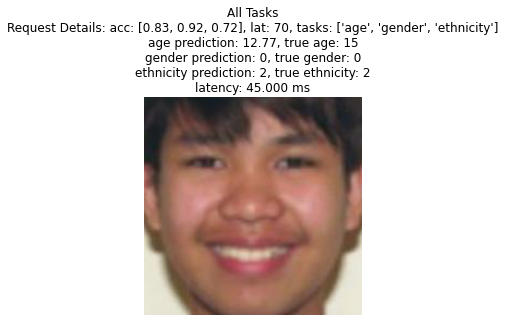

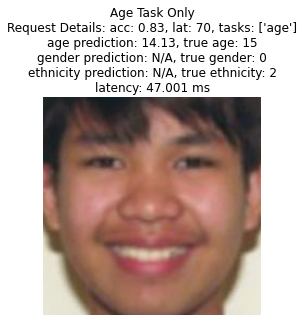

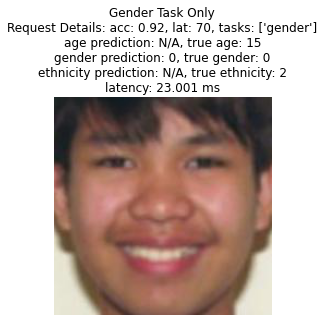

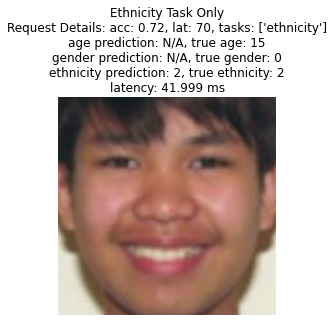

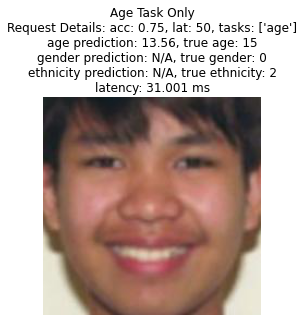

In [39]:
for i, output in enumerate(outputs):
    request_details = f'Request Details: acc: {requests[i].accuracy}, lat: {requests[i].latency}, tasks: {requests[i].tasks}'
    if len(output) == 3:
        pred_age = str(round(output[0], 2))
        pred_gender = str(round(output[1], 2))
        pred_ethnicity = str(round(output[2], 2))
        main_title='All Tasks'
    if i == 1:
        pred_age = str(round(output[0], 2))
        pred_gender = 'N/A'
        pred_ethnicity = 'N/A'
        main_title='Age Task Only'
    if i == 2:
        pred_age = 'N/A'
        pred_gender = str(round(output[0], 2))
        pred_ethnicity = 'N/A' 
        main_title='Gender Task Only'
    if i == 3:
        pred_age = 'N/A'
        pred_gender = 'N/A'
        pred_ethnicity = str(round(output[0], 2))
        main_title='Ethnicity Task Only'
    if i == 4:
        pred_age = str(round(output[0], 2))
        pred_gender = 'N/A'
        pred_ethnicity = 'N/A'
        main_title='Age Task Only'
        
    plt.axis('off')
    plt.title(f'''{main_title}\n{request_details}\nage prediction: {pred_age}, true age: {age}\ngender prediction: {pred_gender}, true gender: {gender}\nethnicity prediction: {pred_ethnicity}, true ethnicity: {ethnicity}\nlatency: {latencies[i]:.3f} ms''')
    plt.imshow(input_image.permute(1, 2, 0))
    plt.show()